# Random Forest: Hyperparameter Optimization

*   Jacob Yousif

## Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%capture
!pip install optuna==3.6.1

In [5]:
%%capture

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Process

In [7]:
npz_file_path = 'datasets/hypertuning_train_set/LearningSet.npz'
data = np.load(npz_file_path, allow_pickle=True)

In [8]:
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
features = data['feature_names']

In [9]:
features

array(['Duration', 'ProtocolCode', 'ServiceCode', 'StateCode',
       'SourcePackets', 'DestinationPackets', 'SourceBytes',
       'DestinationBytes', 'FlowRate', 'SourceTTL', 'DestinationTTL',
       'SourceLoad', 'DestinationLoad', 'SourceLoss', 'DestinationLoss',
       'SourceInterPacketTime', 'DestinationInterPacketTime',
       'SourceJitter', 'DestinationJitter', 'SourceTCPWindow',
       'SourceTCPBaseSequence', 'DestinationTCPBaseSequence',
       'DestinationTCPWindow', 'TCPRTT', 'TCPSYNACK', 'TCPACKDelta',
       'SourcePacketMeanSize', 'DestinationPacketMeanSize',
       'TransactionDepth', 'ResponseBodyLength', 'RecordServiceSource',
       'RecordStateTTL', 'RecordDestinationLTM', 'RecordSourceDPortLTM',
       'RecordDestinationSPortLTM', 'RecordDestinationSourceLTM',
       'IsFTPLogin', 'RecordFTPCommands', 'RecordFlowHTTPMethods',
       'RecordSourceLTM', 'RecordServiceDestination', 'IsSmallIPSPorts'],
      dtype='<U26')

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (113921, 42)
y_train shape: (113921,)
X_val shape: (24412, 42)
y_val shape: (24412,)


In [11]:
results = []
total = 0
best_accuracy = 0.0

In [12]:
def objective(trial):
    global total
    global results
    global best_accuracy

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [None, 3, 5, 7, 9, 10, 15, 20, 25, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    clf = RandomForestClassifier(**params, random_state=42)
    start_time = time.time()
    clf.fit(X_train, y_train)
    duration = time.time() - start_time
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    total += duration

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    results.append({
        'Trial': trial.number,
        'Accuracy': accuracy,
        'Duration': duration,
        'Params': params,
        'BestAccuracy': best_accuracy
    })

    return accuracy

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [14]:
seconds = int(total)
print('Total duration of the hypertuning process in seconds:', seconds, 'seconds.')

Total duration of the hypertuning process in seconds: 17673 seconds.


In [15]:
minutes = int(total / 60)
print('Total duration in minutes:', minutes, 'minutes.')

Total duration in minutes: 294 minutes.


In [16]:
hours = round(total / 3600, 1)
print('Total duration in hours:', hours, 'hours.')

Total duration in hours: 4.9 hours.


In [17]:
progress = pd.DataFrame(results)

In [18]:
progress

,Trial,Accuracy,Duration,Params,BestAccuracy
0,0,0.810503,261.390042,"{'n_estimators': 584, 'max_depth': 20, 'min_sa...",0.810503
1,1,0.776217,110.081856,"{'n_estimators': 402, 'max_depth': 7, 'min_sam...",0.810503
2,2,0.789530,915.791048,"{'n_estimators': 639, 'max_depth': 10, 'min_sa...",0.810503
3,3,0.725668,351.645198,"{'n_estimators': 804, 'max_depth': 5, 'min_sam...",0.810503
4,4,0.809110,127.856913,"{'n_estimators': 845, 'max_depth': 20, 'min_sa...",0.810503
...,...,...,...,...,...
95,95,0.816648,241.622293,"{'n_estimators': 751, 'max_depth': 30, 'min_sa...",0.816770
96,96,0.815501,241.880344,"{'n_estimators': 765, 'max_depth': None, 'min_...",0.816770
97,97,0.816238,224.577547,"{'n_estimators': 712, 'max_depth': 30, 'min_sa...",0.816770
98,98,0.815787,427.113360,"{'n_estimators': 839, 'max_depth': 30, 'min_sa...",0.816770


In [19]:
csv_file_path = 'results/RandomForestHypertuningProgress.csv'
progress.to_csv(csv_file_path, index=False)

In [20]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 645, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}


In [21]:
clf = RandomForestClassifier(**best_params, random_state=42)

In [22]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=9,
                       n_estimators=645, random_state=42)

In [23]:
joblib.dump(clf, 'models/RandomForestModel.joblib')

['models/RandomForestModel.joblib']

In [24]:
feature_importances = clf.feature_importances_

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

In [26]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

In [27]:
top_n = 10
top_features = feature_importance_df.head(top_n)

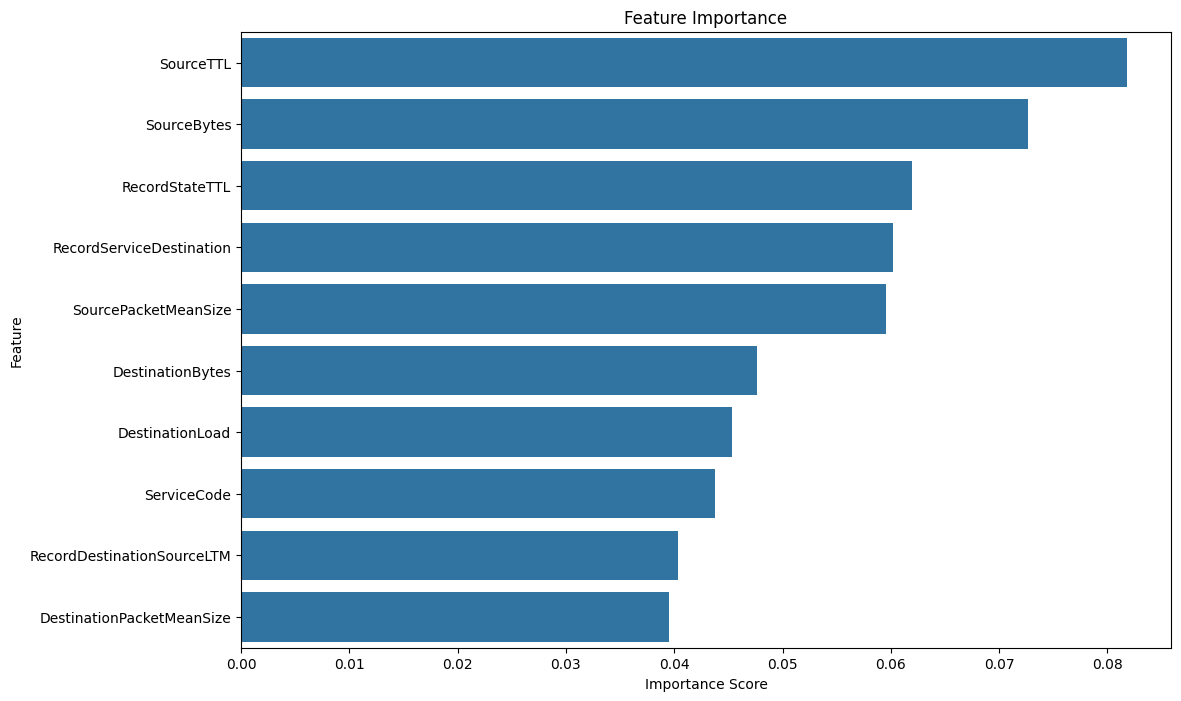

In [28]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig('figures/features/RandomForestFeatureImportance.pdf', bbox_inches='tight')
plt.show()

In [29]:
feature_importance_df.to_csv('results/RandomForestFeatureImportance.csv', index=False)

In [30]:
feature_importance_df

,Feature,Importance
0,SourceTTL,0.081785
1,SourceBytes,0.072693
2,RecordStateTTL,0.061939
3,RecordServiceDestination,0.060182
4,SourcePacketMeanSize,0.059589
5,DestinationBytes,0.047634
6,DestinationLoad,0.045310
7,ServiceCode,0.043730
8,RecordDestinationSourceLTM,0.040306
9,DestinationPacketMeanSize,0.039560


In [31]:
feature_importance_df.columns

Index(['Feature', 'Importance'], dtype='object')